# Genetic algorithms experiments
![](https://cdn.atelier.bnpparibas/media/cache/archive/uploads/image/434150_atelier-chaine-adn.jpg)

##### References
- The excellent [blog post](http://blog.otoro.net/2017/10/29/visual-evolution-strategies/) on Otoro.net
- [Siraj Raval video](https://www.youtube.com/watch?v=rGWBo0JGf50) and [repo](https://github.com/llSourcell/Evolutionary_Space_Invaders)

In [1]:
# Usual
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
import time
from tqdm import tqdm

# Autoreload
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
%matplotlib inline

In [2]:
plt.style.use('ggplot')
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['grid.color'] = "#d4d4d4"
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 10
plt.rcParams['lines.linewidth'] = 2

# Fitting a normal distribution

## Generate data

In [4]:
from scipy import stats

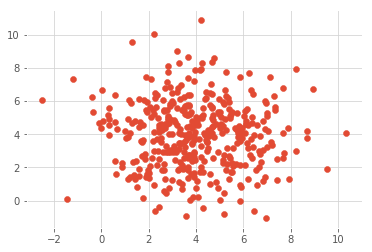

In [5]:
x1 = stats.norm.rvs(loc = 4,scale = 2,size = 400)
y1 = stats.norm.rvs(loc = 4,scale = 2,size = 400)

plt.scatter(x1,y1)
plt.show()

## Define objects

### Define a normal distribution

In [134]:
np.mean([1,2])

1.5

In [360]:
class Dist(object):
    def __init__(self,mu = None,std = None,label = None):
        self.mu = np.random.rand()*20 - 10 if mu is None else mu
        self.std = np.random.rand()*10 if std is None else std
        self.label = "" if not label else " - "+label
        self.func = lambda x : stats.norm.cdf(x,loc = self.mu,scale = self.std)
        
    def __repr__(self,markdown = False):
        return "Norm {1}mu={2}{0}, {0}std={3}{0}{4}".format("$" if markdown else "","$\\" if markdown else "",
                                                             round(self.mu,2),round(self.std,2),self.label)
        
    def plot(self,fill = True):
        x = np.linspace(-20, 20, 100)
        y = stats.norm.pdf(x,loc = self.mu,scale = self.std)
        plt.plot(x,y,label = self.__repr__(markdown = True))
        if fill:
            plt.fill_between(x, 0, y, alpha=0.4)
        
        
    def __add__(self,other):
        mu = np.mean([self.mu,other.mu])
        std = np.mean([self.std,other.std])
        return Dist(mu,std)
    
    def mutate(self,alpha = 1):
        self.mu = self.mu + 1/(1+np.log(1+alpha)) * np.random.randn()
        self.std = max(self.std + 1/(1+np.log(1+alpha)) * np.random.randn(),0.5)
        
    def fitness(self,x):
        return 1 - stats.kstest(x,self.func).statistic

In [205]:
d = Dist(4,2,label = "True")
d2 = Dist(-4,1)
print(d)
print(d2)

Norm mu=4, std=2 - True
Norm mu=-4, std=1


In [206]:
d + d2

Norm mu=0.0, std=1.5

In [207]:
d2.mutate()
d2

Norm mu=-2.72, std=0.51

### Define a population of distributions

In [369]:
class Population(object):
    def __init__(self,distributions = None,n = 100):
        if distributions is not None:
            self.distributions = distributions
        else:
            self.distributions = [Dist() for i in range(n)]
            
    def __getitem__(self,key):
        if type(key) == tuple or type(key) == list:
            d = []
            for i in key:
                d.append(self.distributions[i])
            return d
        else:
            return self.distributions[key]
    
    def __iter__(self):
        return iter(self.distributions)
    
    def __len__(self):
        return len(self.distributions)
    
    def plot(self,title = "Normal distributions",figsize = None):
        if figsize:
            plt.figure(figsize = figsize)
        plt.title(title)
        fill = len(self) < 5
        for d in self:
            d.plot(fill = fill)
        plt.legend()
        plt.xlabel("x")
        plt.show()
    
    def evaluate(self,x):
        fitnesses = [(i,dist.fitness(x)) for i,dist in enumerate(self)]
        indices,fitnesses = zip(*sorted(fitnesses,key = lambda x : x[1],reverse = True))
        return indices,fitnesses
    
    def selection(self,x,top = 0.1):
        indices,fitnesses = self.evaluate(x)
        n = int(top*len(fitnesses))
        return indices[:n]
    
    
    def crossover(self,indices):
        combinations = list(itertools.combinations(indices,2))
        np.random.shuffle(combinations)
        combinations = combinations[:len(self)]
        new_population = []
        for i,j in combinations:
            new_population.append(self[i]+self[j])
        self.distributions = new_population
            
    def mutate(self,generation = 1):
        for d in self:
            d.mutate(generation)
            
            
    def evolve(self,x,top = 0.25,n_generations = 20,last_selection = True):
        all_fitnesses = [self.evaluate(x)[1]]

        for generation in tqdm(range(n_generations)):

            indices = self.selection(x,top)
            self.crossover(indices)
            self.mutate(generation)
            
            indices,fitnesses = self.evaluate(x)
            all_fitnesses.append(fitnesses)
            
        self._plot_fitnesses(all_fitnesses)
        
        if last_selection:
            indices = self.selection(x,top)
    
        return Population(self[indices])
    
    
    def _plot_fitnesses(self,fitnesses):
        sups = []
        infs = []
        means = []
        for step in fitnesses:
            sups.append(np.max(step))
            infs.append(np.min(step))
            means.append(np.mean(step))
            
        plt.figure(figsize=(10,6))
        plt.plot(means)
        plt.fill_between(range(len(means)),sups,infs, alpha = 0.2)
        plt.xlabel('# Generation')
        plt.ylabel('Fitness')
        plt.legend()
        plt.show()

In [373]:
pop = Population(n = 3)

In [374]:
pop[0]

Norm mu=-0.4, std=5.98

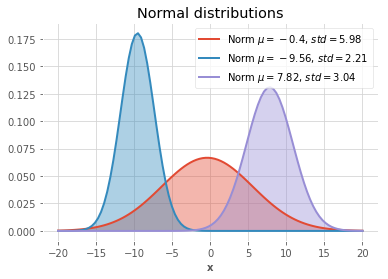

In [375]:
pop.plot()

## Create the fitness function

##### Test of the Kolmogorov-Smirnov test

In [103]:
import seaborn as sns

In [124]:
mus = np.linspace(0,5,100)
stds = np.linspace(1,5,50)
ks = []
for std in stds:
    ksi = []
    for mu in mus: 
        ksi.append(stats.kstest(x1,Dist(mu,std).func).statistic)
    ks.append(ksi)

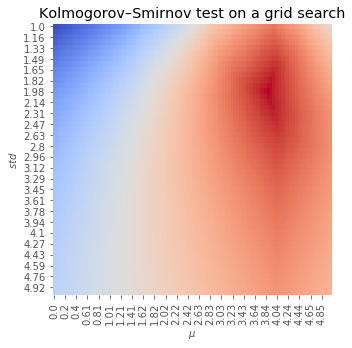

In [132]:
plt.figure(figsize = (5,5))
plt.title("Kolmogorov–Smirnov test on a grid search")
sns.heatmap(pd.DataFrame(ks,columns = np.round(mus,2),index = np.round(stds,2)),cbar = False,cmap = plt.cm.coolwarm_r)
plt.xlabel("$\mu$")
plt.ylabel("$std$")
plt.show()

## Genetic algorithm

In [376]:
pop = Population(n = 50)

100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 28.45it/s]


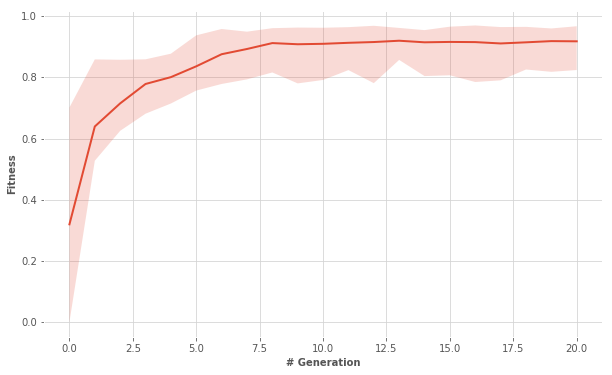

In [377]:
new_pop = pop.evolve(x1,n_generations=20)

In [378]:
len(new_pop)

12

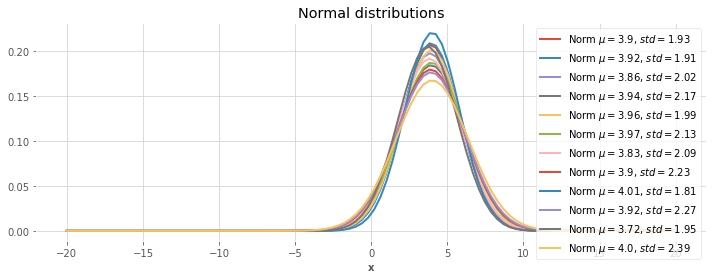

In [379]:
new_pop.plot(figsize = (12,4))